# Chapter5 再帰型ニューラルネットワーク（時系列データの予測）　～株価予測プログラムを作る～
## 2. 株価予測【サンプルコード】

In [ ]:
# 必要なパッケージのインストール
!pip3 install torch==1.6.0+cu101
!pip3 install torchvision==0.7.0+cu101
!pip3 install numpy==1.18.5
!pip3 install matplotlib==3.2.2
!pip3 install scikit-learn==0.23.1
!pip3 install seaborn==0.11.0

     |████████████████████████████████| 6.9MB 6.4MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


## 2.1. 前準備（パッケージのインポート）

In [ ]:
# 必要なパッケージのインストール
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim

## 2.2. 訓練データとテストデータの用意

In [ ]:
# 株価データ(prices.csv)のアップロード
# コマンドを実行後、「ファイル選択」ボタンを押して「prices.csv」を選択してください。
from google.colab import files
uploaded = files.upload()

Saving prices.csv to prices.csv


In [ ]:
# 株価データ(prices.csv)の読み込み
dataset = pd.read_csv('prices.csv')
# datasetの中身を確認
print(dataset.head())

                  date symbol        open  ...         low        high     volume
0  2016-01-05 00:00:00   WLTW  123.430000  ...  122.309998  126.250000  2163600.0
1  2016-01-06 00:00:00   WLTW  125.239998  ...  119.940002  125.540001  2386400.0
2  2016-01-07 00:00:00   WLTW  116.379997  ...  114.930000  119.739998  2489500.0
3  2016-01-08 00:00:00   WLTW  115.480003  ...  113.500000  117.440002  2006300.0
4  2016-01-11 00:00:00   WLTW  117.010002  ...  114.089996  117.330002  1408600.0

[5 rows x 7 columns]


In [ ]:
# 銘柄(symbol)の確認
symbols = list(set(dataset.symbol))
len("The number of symbols: {}".format(symbols))  # 銘柄数
print(symbols[:10])  # 10件の銘柄を表示

['O', 'KR', 'CTSH', 'IPG', 'EOG', 'AAP', 'FFIV', 'FBHS', 'AME', 'GPN']


In [ ]:
# ヤフー(YHOO)のみを抽出
dataset = dataset[dataset['symbol'] == 'YHOO']
print(dataset.head())

            date symbol       open      close        low       high      volume
713   2010-01-04   YHOO  16.940001  17.100000  16.879999  17.200001  16587400.0
1181  2010-01-05   YHOO  17.219999  17.230000  17.000000  17.230000  11718100.0
1649  2010-01-06   YHOO  17.170000  17.170000  17.070000  17.299999  16422000.0
2117  2010-01-07   YHOO  16.809999  16.700001  16.570000  16.900000  31816300.0
2585  2010-01-08   YHOO  16.680000  16.700001  16.620001  16.760000  15470000.0


In [ ]:
# 始値(open)、安値(low)、高値(high)、出来高(volume)を消して、終値(close)のみを残す
dataset = dataset.drop(['open', 'low', 'high', 'volume'], axis=1)
print(dataset.head())

            date symbol      close
713   2010-01-04   YHOO  17.100000
1181  2010-01-05   YHOO  17.230000
1649  2010-01-06   YHOO  17.170000
2117  2010-01-07   YHOO  16.700001
2585  2010-01-08   YHOO  16.700001


In [ ]:
# 終値の25日移動平均(25MA)を算出
dataset['25MA'] = dataset['close'].rolling(window=25, min_periods=0).mean()
print(dataset.head())

            date symbol      close       25MA
713   2010-01-04   YHOO  17.100000  17.100000
1181  2010-01-05   YHOO  17.230000  17.165000
1649  2010-01-06   YHOO  17.170000  17.166667
2117  2010-01-07   YHOO  16.700001  17.050000
2585  2010-01-08   YHOO  16.700001  16.980000


In [ ]:
# 日付(date)をobject型からdatetime64型に変換
print(dataset['date'].dtype)  # 変換前のデータ型
dataset['date'] = pd.to_datetime(dataset['date'])
print(dataset['date'].dtype)  # 変換後のデータ型

object
datetime64[ns]


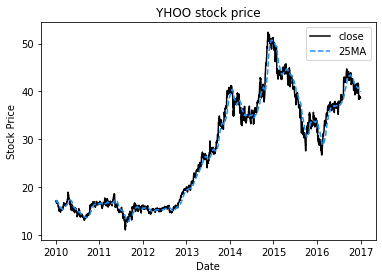

In [ ]:
# 終値と25日移動平均を図示
plt.figure()
plt.title('YHOO stock price')
plt.xlabel('Date')
plt.ylabel('Stock Price')
# plt.xticks(np.arange(0, 180 + 1, 30))
# plt.xticks(dataset['date'][::10].values)
plt.plot(dataset['date'], dataset['close'], color='black',
         linestyle='-', label='close')
plt.plot(dataset['date'], dataset['25MA'], color='dodgerblue',
         linestyle='--', label='25MA')
plt.legend()  # 凡例
plt.savefig('5-2_stock_price.png')  # 図の保存
plt.show()

In [ ]:
# 標準化
ma = dataset['25MA'].values.reshape(-1, 1)
scaler = StandardScaler()
ma_std = scaler.fit_transform(ma)
print("ma: {}".format(ma))
print("ma_std: {}".format(ma_std))

ma: [[17.1       ]
 [17.165     ]
 [17.16666667]
 ...
 [40.1083998 ]
 [40.01359984]
 [39.9219998 ]]
ma_std: [[-0.88504099]
 [-0.87931043]
 [-0.8791635 ]
 ...
 [ 1.14343482]
 [ 1.13507703]
 [ 1.12700135]]


In [ ]:
# 現在から過去25日分の株価の移動平均を入力値として、1日後の株価の移動平均を予測
data = []  # 入力データ(過去25日分の移動平均)
label = []  # 出力データ(1日後の移動平均)
for i in range(len(ma_std) - 25):
    data.append(ma_std[i:i + 25])
    label.append(ma_std[i + 25])
# ndarrayに変換
data = np.array(data)
label = np.array(label)
print("data size: {}".format(data.shape))
print("label size: {}".format(label.shape))

data size: (1737, 25, 1)
label size: (1737, 1)


In [ ]:
# 訓練データとテストデータのサイズを決定
test_len = int(252)  # 1年分(252日分)
train_len = int(data.shape[0] - test_len)
# 訓練データの準備
train_data = data[:train_len]
train_label = label[:train_len]
# テストデータの準備
test_data = data[train_len:]
test_label = label[train_len:]
# データの形状を確認
print("train_data size: {}".format(train_data.shape))
print("test_data size: {}".format(test_data.shape))
print("train_label size: {}".format(train_label.shape))
print("test_label size: {}".format(test_label.shape))

train_data size: (1485, 25, 1)
test_data size: (252, 25, 1)
train_label size: (1485, 1)
test_label size: (252, 1)


In [ ]:
# ndarrayをPyTorchのTensorに変換
train_x = torch.Tensor(train_data)
test_x = torch.Tensor(test_data)
train_y = torch.Tensor(train_label)
test_y = torch.Tensor(test_label)

In [ ]:
# 特徴量とラベルを結合したデータセットを作成
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

In [ ]:
# ミニバッチサイズを指定したデータローダーを作成
train_batch = DataLoader(
    dataset=train_dataset,  # データセットの指定
    batch_size=128,  # バッチサイズの指定
    shuffle=True,  # シャッフルするかどうかの指定
    num_workers=2)  # コアの数
test_batch = DataLoader(
    dataset=test_dataset,
    batch_size=128,
    shuffle=False,
    num_workers=2)
# ミニバッチデータセットの確認
for data, label in train_batch:
    print("batch data size: {}".format(data.size()))  # バッチの入力データサイズ
    print("batch label size: {}".format(label.size()))  # バッチのラベルサイズ
    break

batch data size: torch.Size([128, 25, 1])
batch label size: torch.Size([128, 1])


## 2.3. ニューラルネットワークの定義

In [ ]:
# ニューラルネットワークの定義
class Net(nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(D_in, H, batch_first=True,
                            num_layers=1)
        self.linear = nn.Linear(H, D_out)

    def forward(self, x):
        output, (hidden, cell) = self.lstm(x)
        output = self.linear(output[:, -1, :])  # 最後のステップのみを入力
        return output

In [ ]:
# ハイパーパラメータの定義
D_in = 1  # 入力次元: 1
H = 200  # 隠れ層次元: 200
D_out = 1  # 出力次元: 1
epoch = 100  # 学習回数: 100

In [ ]:
# ネットワークのロード
# CPUとGPUどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net(D_in, H, D_out).to(device)
# デバイスの確認
print("Device: {}".format(device))

Device: cuda


## 2.4. 損失関数と最適化関数の定義

In [ ]:
# 損失関数の定義
criterion = nn.MSELoss()  # 損失関数（平均二乗誤差: MSE）

# 最適化関数の定義
optimizer = optim.Adam(net.parameters())

## 2.5. 学習

In [ ]:
# 損失を保存するリストを作成
train_loss_list = []  # 学習損失
test_loss_list = []  # 評価損失

# 学習（エポック）の実行
for i in range(epoch):
    # エポックの進行状況を表示
    print('---------------------------------------------')
    print("Epoch: {}/{}".format(i+1, epoch))

    # 損失の初期化
    train_loss = 0  # 学習損失
    test_loss = 0  # 評価損失

    # ---------学習パート--------- #
    # ニューラルネットワークを学習モードに設定
    net.train()
    # ミニバッチごとにデータをロードし学習
    for data, label in train_batch:
        # GPUにTensorを転送
        data = data.to(device)
        label = label.to(device)

        # 勾配を初期化
        optimizer.zero_grad()
        # データを入力して予測値を計算（順伝播）
        y_pred = net(data)
        # 損失（誤差）を計算
        loss = criterion(y_pred, label)
        # 勾配の計算（逆伝搬）
        loss.backward()
        # パラメータ（重み）の更新
        optimizer.step()
        # ミニバッチごとの損失を蓄積
        train_loss += loss.item()

    # ミニバッチの平均の損失を計算
    batch_train_loss = train_loss / len(train_batch)
    # ---------学習パートはここまで--------- #

    # ---------評価パート--------- #
    # ニューラルネットワークを評価モードに設定
    net.eval()
    # 評価時の計算で自動微分機能をオフにする
    with torch.no_grad():
        for data, label in test_batch:
            # GPUにTensorを転送
            data = data.to(device)
            label = label.to(device)
            # データを入力して予測値を計算（順伝播）
            y_pred = net(data)
            # 損失（誤差）を計算
            loss = criterion(y_pred, label)
            # ミニバッチごとの損失を蓄積
            test_loss += loss.item()

    # ミニバッチの平均の損失を計算
    batch_test_loss = test_loss / len(test_batch)
    # ---------評価パートはここまで--------- #

    # エポックごとに損失を表示
    print("Train_Loss: {:.2E} Test_Loss: {:.2E}".format(
        batch_train_loss, batch_test_loss))
    # 損失をリスト化して保存
    train_loss_list.append(batch_train_loss)
    test_loss_list.append(batch_test_loss)

---------------------------------------------
Epoch: 1/100
Train_Loss: 6.16E-01 Test_Loss: 6.42E-02
---------------------------------------------
Epoch: 2/100
Train_Loss: 7.01E-02 Test_Loss: 1.60E-02
---------------------------------------------
Epoch: 3/100
Train_Loss: 2.06E-02 Test_Loss: 9.48E-03
---------------------------------------------
Epoch: 4/100
Train_Loss: 1.04E-02 Test_Loss: 6.52E-03
---------------------------------------------
Epoch: 5/100
Train_Loss: 7.33E-03 Test_Loss: 4.43E-03
---------------------------------------------
Epoch: 6/100
Train_Loss: 5.58E-03 Test_Loss: 3.70E-03
---------------------------------------------
Epoch: 7/100
Train_Loss: 4.38E-03 Test_Loss: 3.39E-03
---------------------------------------------
Epoch: 8/100
Train_Loss: 3.55E-03 Test_Loss: 2.99E-03
---------------------------------------------
Epoch: 9/100
Train_Loss: 3.02E-03 Test_Loss: 2.75E-03
---------------------------------------------
Epoch: 10/100
Train_Loss: 2.51E-03 Test_Loss: 2.52E-03

## 2.6. 結果の可視化

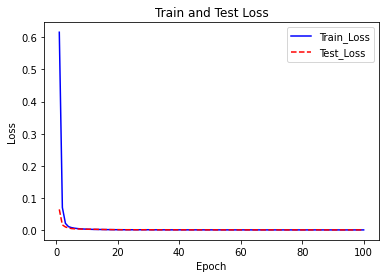

In [ ]:
# 損失
plt.figure()
plt.title('Train and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), train_loss_list, color='blue',
         linestyle='-', label='Train_Loss')
plt.plot(range(1, epoch+1), test_loss_list, color='red',
         linestyle='--', label='Test_Loss')
plt.legend()  # 凡例
plt.show()  # 表示

## 2.7. テストデータに対する予測の評価

In [ ]:
# ニューラルネットワークを評価モードに設定
net.eval()
# 推定時の計算で自動微分機能をオフにする
with torch.no_grad():
    # 初期化
    pred_ma = []
    true_ma = []
    for data, label in test_batch:
        # GPUにTensorを転送
        data = data.to(device)
        label = label.to(device)
        # データを入力して予測値を計算（順伝播）
        y_pred = net(data)
        pred_ma.append(y_pred.view(-1).tolist())  # Tensorを1次元listに変換
        true_ma.append(label.view(-1).tolist())

In [ ]:
# Tensorを数値データを取り出す
pred_ma = [elem for lst in pred_ma for elem in lst]  # listを1次元配列に
true_ma = [elem for lst in true_ma for elem in lst]

# 標準化を解除して元の株価に変換
pred_ma = scaler.inverse_transform(pred_ma)
true_ma = scaler.inverse_transform(true_ma)

In [ ]:
# 平均絶対誤差を計算
mae = mean_absolute_error(true_ma, pred_ma)
print("MAE: {:.3f}".format(mae))

MAE: 0.155


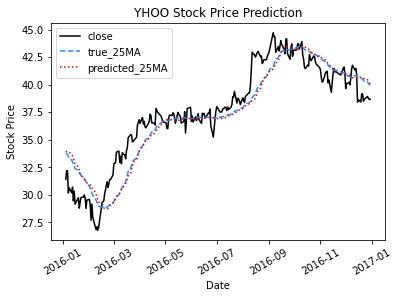

In [ ]:
# 終値と25日移動平均を図示
date = dataset['date'][-1*test_len:]  # テストデータの日付
test_close = dataset['close'][-1*test_len:].values.reshape(-1)  # テストデータの終値
plt.figure()
plt.title('YHOO Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.plot(date, test_close, color='black',
         linestyle='-', label='close')
plt.plot(date, true_ma, color='dodgerblue',
         linestyle='--', label='true_25MA')
plt.plot(date, pred_ma, color='red',
         linestyle=':', label='predicted_25MA')
plt.legend()  # 凡例
plt.xticks(rotation=30)  # x軸ラベルを30度回転して表示
plt.show()